In [30]:
import cv2 as cv
import numpy as np
import tensorflow as tf
import sys
sys.path.insert(0, "../")
from deeparuco.impl.losses import weighted_loss
from deeparuco.impl.utils import ordered_corners, custom_marker_from_corners
from deeparuco.impl.customTag import find_id
from tensorflow.keras.models import load_model
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
import pandas as pd
import json
import time
import csv 
from tensorflow.keras.saving import register_keras_serializable
from keras.metrics import mean_absolute_error

# Register the custom function
@register_keras_serializable(package="Custom", name="extract_border")
def extract_border(x):
    # Extracting the outer border elements in clockwise order, starting from [0, 0] and ending at [1, 0]
    top_row = x[:, 0, :]         # First row (top border)
    bottom_row = x[:, -1, :]     # Last row (bottom border)
    left_column = x[:, 1:-1, 0]  # Left column, excluding top and bottom corners
    right_column = x[:, 1:-1, -1]  # Right column, excluding top and bottom corners
    
    # Concatenate the border elements in a specific clockwise order
    outer_border = tf.concat([
        top_row,                   # From [0, 0] to [0, 13]
        right_column,              # From [1, 13] to [12, 13]
        bottom_row[:, ::-1],       # From [13, 13] to [13, 0] (reverse order)
        left_column[::-1]          # From [12, 0] to [1, 0] (reverse order)
    ], axis=1)

    return outer_border

In [31]:
decoder = load_model("../models/nested2_decoder/decoder.keras")

In [40]:
@tf.function(reduce_retracing=True)
def decode_markers(markers):
    return decoder(markers)

start_time = time.time()

csv_path    = '../dataset/nested2/crops/test128.csv'
label_dir   = '../dataset/nested2/labels/test/'
crop_dir    = '../dataset/nested2/crops/test/'
detect_path = '../dataset/nested2/detect_eval_model_n.csv'
eval_path   = '../dataset/nested2/decode_eval_model.csv'

dfd = pd.read_csv(detect_path)
dfd = dfd.loc[dfd['TP'] == 1]
df = pd.read_csv(csv_path)

with open(eval_path, 'a', newline='') as eval_file:
    csv_writer = csv.writer(eval_file)
    csv_writer.writerow(['image', 'location', 'reflection', 'marker_size', 'TP', 'FN'])

    num_match = 0

    rot_codes = [cv.ROTATE_90_CLOCKWISE, cv.ROTATE_180, cv.ROTATE_90_COUNTERCLOCKWISE]
    for i in range(dfd.shape[0]):
        id = dfd.iloc[i][1]
        filename = dfd.iloc[i][0] + '_' + id + '.jpg'
        
        row = df[df['pic'] == filename]
        crop_path = crop_dir + row.iloc[0][0]
        crop = cv.imread(crop_path, cv.IMREAD_GRAYSCALE)

        c1_x = float(row.iloc[0][1])
        c1_y = float(row.iloc[0][2])
        c2_x = float(row.iloc[0][3])
        c2_y = float(row.iloc[0][4])
        c3_x = float(row.iloc[0][5])
        c3_y = float(row.iloc[0][6])
        c4_x = float(row.iloc[0][7])
        c4_y = float(row.iloc[0][8])
        corners = np.array([c1_x, c1_y, c2_x, c2_y, c3_x, c3_y, c4_x, c4_y])
        marker = custom_marker_from_corners(crop, corners, 128)

        orientation = row.iloc[0][10]
        if orientation != 0:
            marker = cv.rotate(marker, rot_codes[orientation - 1])

        markers = [marker]

        decoder_out = np.round(decode_markers(np.array(markers)).numpy())
        id, dist = find_id(decoder_out[0])

        true_id = row.iloc[0][9]
        pred_id = id
        TP = 0
        FN = 0
        if true_id == id:
            TP = 1
            num_match += 1
            print(row.iloc[0][0])
        if true_id != id:
            FN = 1
        reflection = row.iloc[0][11]
        location = dfd.iloc[i][2]
        image_name = dfd.iloc[i][0].split('_')[0]
        marker_size = dfd.iloc[i][4]
        csv_writer.writerow([image_name, location, reflection, marker_size, TP, FN])
        
    print(num_match)
    end_time = time.time()


/tmp/ipykernel_4405/3056544922.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  id = dfd.iloc[i][1]
/tmp/ipykernel_4405/3056544922.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filename = dfd.iloc[i][0] + '_' + id + '.jpg'
/tmp/ipykernel_4405/3056544922.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  crop_path = crop_dir + row.iloc[0][0]
/tmp/ipykernel_4405/3056544922.py:32: FutureWarning: Series.__getitem__ treating

06349831cbcb8f2c_26.jpg
1ead457c867be1cd_5.jpg
video-4FRnNpmSmwktFJKjg-frame-000746-9CgazXqHXeEATqtKz_27.jpg
video-4FRnNpmSmwktFJKjg-frame-000746-9CgazXqHXeEATqtKz_0.jpg
8af0b106463da353_27.jpg
8af0b106463da353_28.jpg
video-ePoikf5LyTTfqchga-frame-000433-hmHkcDQSQCzqrP8wR_10.jpg
video-ePoikf5LyTTfqchga-frame-000650-Qyt79x8SvYHboeyng_47.jpg
video-ePoikf5LyTTfqchga-frame-000650-Qyt79x8SvYHboeyng_37.jpg
video-4FRnNpmSmwktFJKjg-frame-000860-gSsyewyQdmuhs64dh_48.jpg
video-4FRnNpmSmwktFJKjg-frame-000860-gSsyewyQdmuhs64dh_24.jpg
video-t3f7QC8hZr6zYXpEZ-frame-000180-KCbuiwR8D8fFGLcLJ_44.jpg
video-SCiKdG3MqZfiE292B-frame-007995-atWouMTCk3mtQ8ura_6.jpg
video-SCiKdG3MqZfiE292B-frame-007995-atWouMTCk3mtQ8ura_44.jpg
video-6tLtjdkv5K5BuhB37-frame-000063-rohYmg56KKKu8aTwA_9.jpg
c5517fa7dabdc6a4_4.jpg
c5517fa7dabdc6a4_43.jpg
video-ePoikf5LyTTfqchga-frame-000637-KwCdaZv9oWkoZKjwA_24.jpg
video-ePoikf5LyTTfqchga-frame-000637-KwCdaZv9oWkoZKjwA_31.jpg
video-t3f7QC8hZr6zYXpEZ-frame-000038-nY6GAWq2koFcjLTZf_

Overall detection rate

In [4]:
num_match / len(dfd)

0.647834274952919

Number of images in which at least one marker is decoded out of the total number of images


In [ ]:
eval_path   = '../dataset/nested2/decode_eval_model.csv'
df = pd.read_csv(eval_path)
unique_image_count = df['image'].nunique()
unique_image_count / 3000

0.999

In [72]:
import pandas as pd

csv_path_model = '../dataset/nested2/detect_decode_eval_model.csv'
df = pd.read_csv(csv_path_model)
dfm = df[df['TP'] == 1]

dfm_outer = dfm[dfm['location'] == 'outer']
dfm_middle = dfm[dfm['location'] == 'middle']
dfm_inner = dfm[dfm['location'] == 'inner']
total = 3000
outer  = len(dfm_outer)  / total
middle = len(dfm_middle) / total
inner  = len(dfm_inner)  / total

unique_image_count = dfm['image'].nunique()

print(f'detection rate of multi: {unique_image_count / total}')
print(f'detection rate of outer: {outer}')
print(f'detection rate of middle: {middle}')
print(f'detection rate of inner: {inner}')


detection rate of multi: 0.849
detection rate of outer: 0.7043333333333334
detection rate of middle: 0.49133333333333334
detection rate of inner: 0.06566666666666666


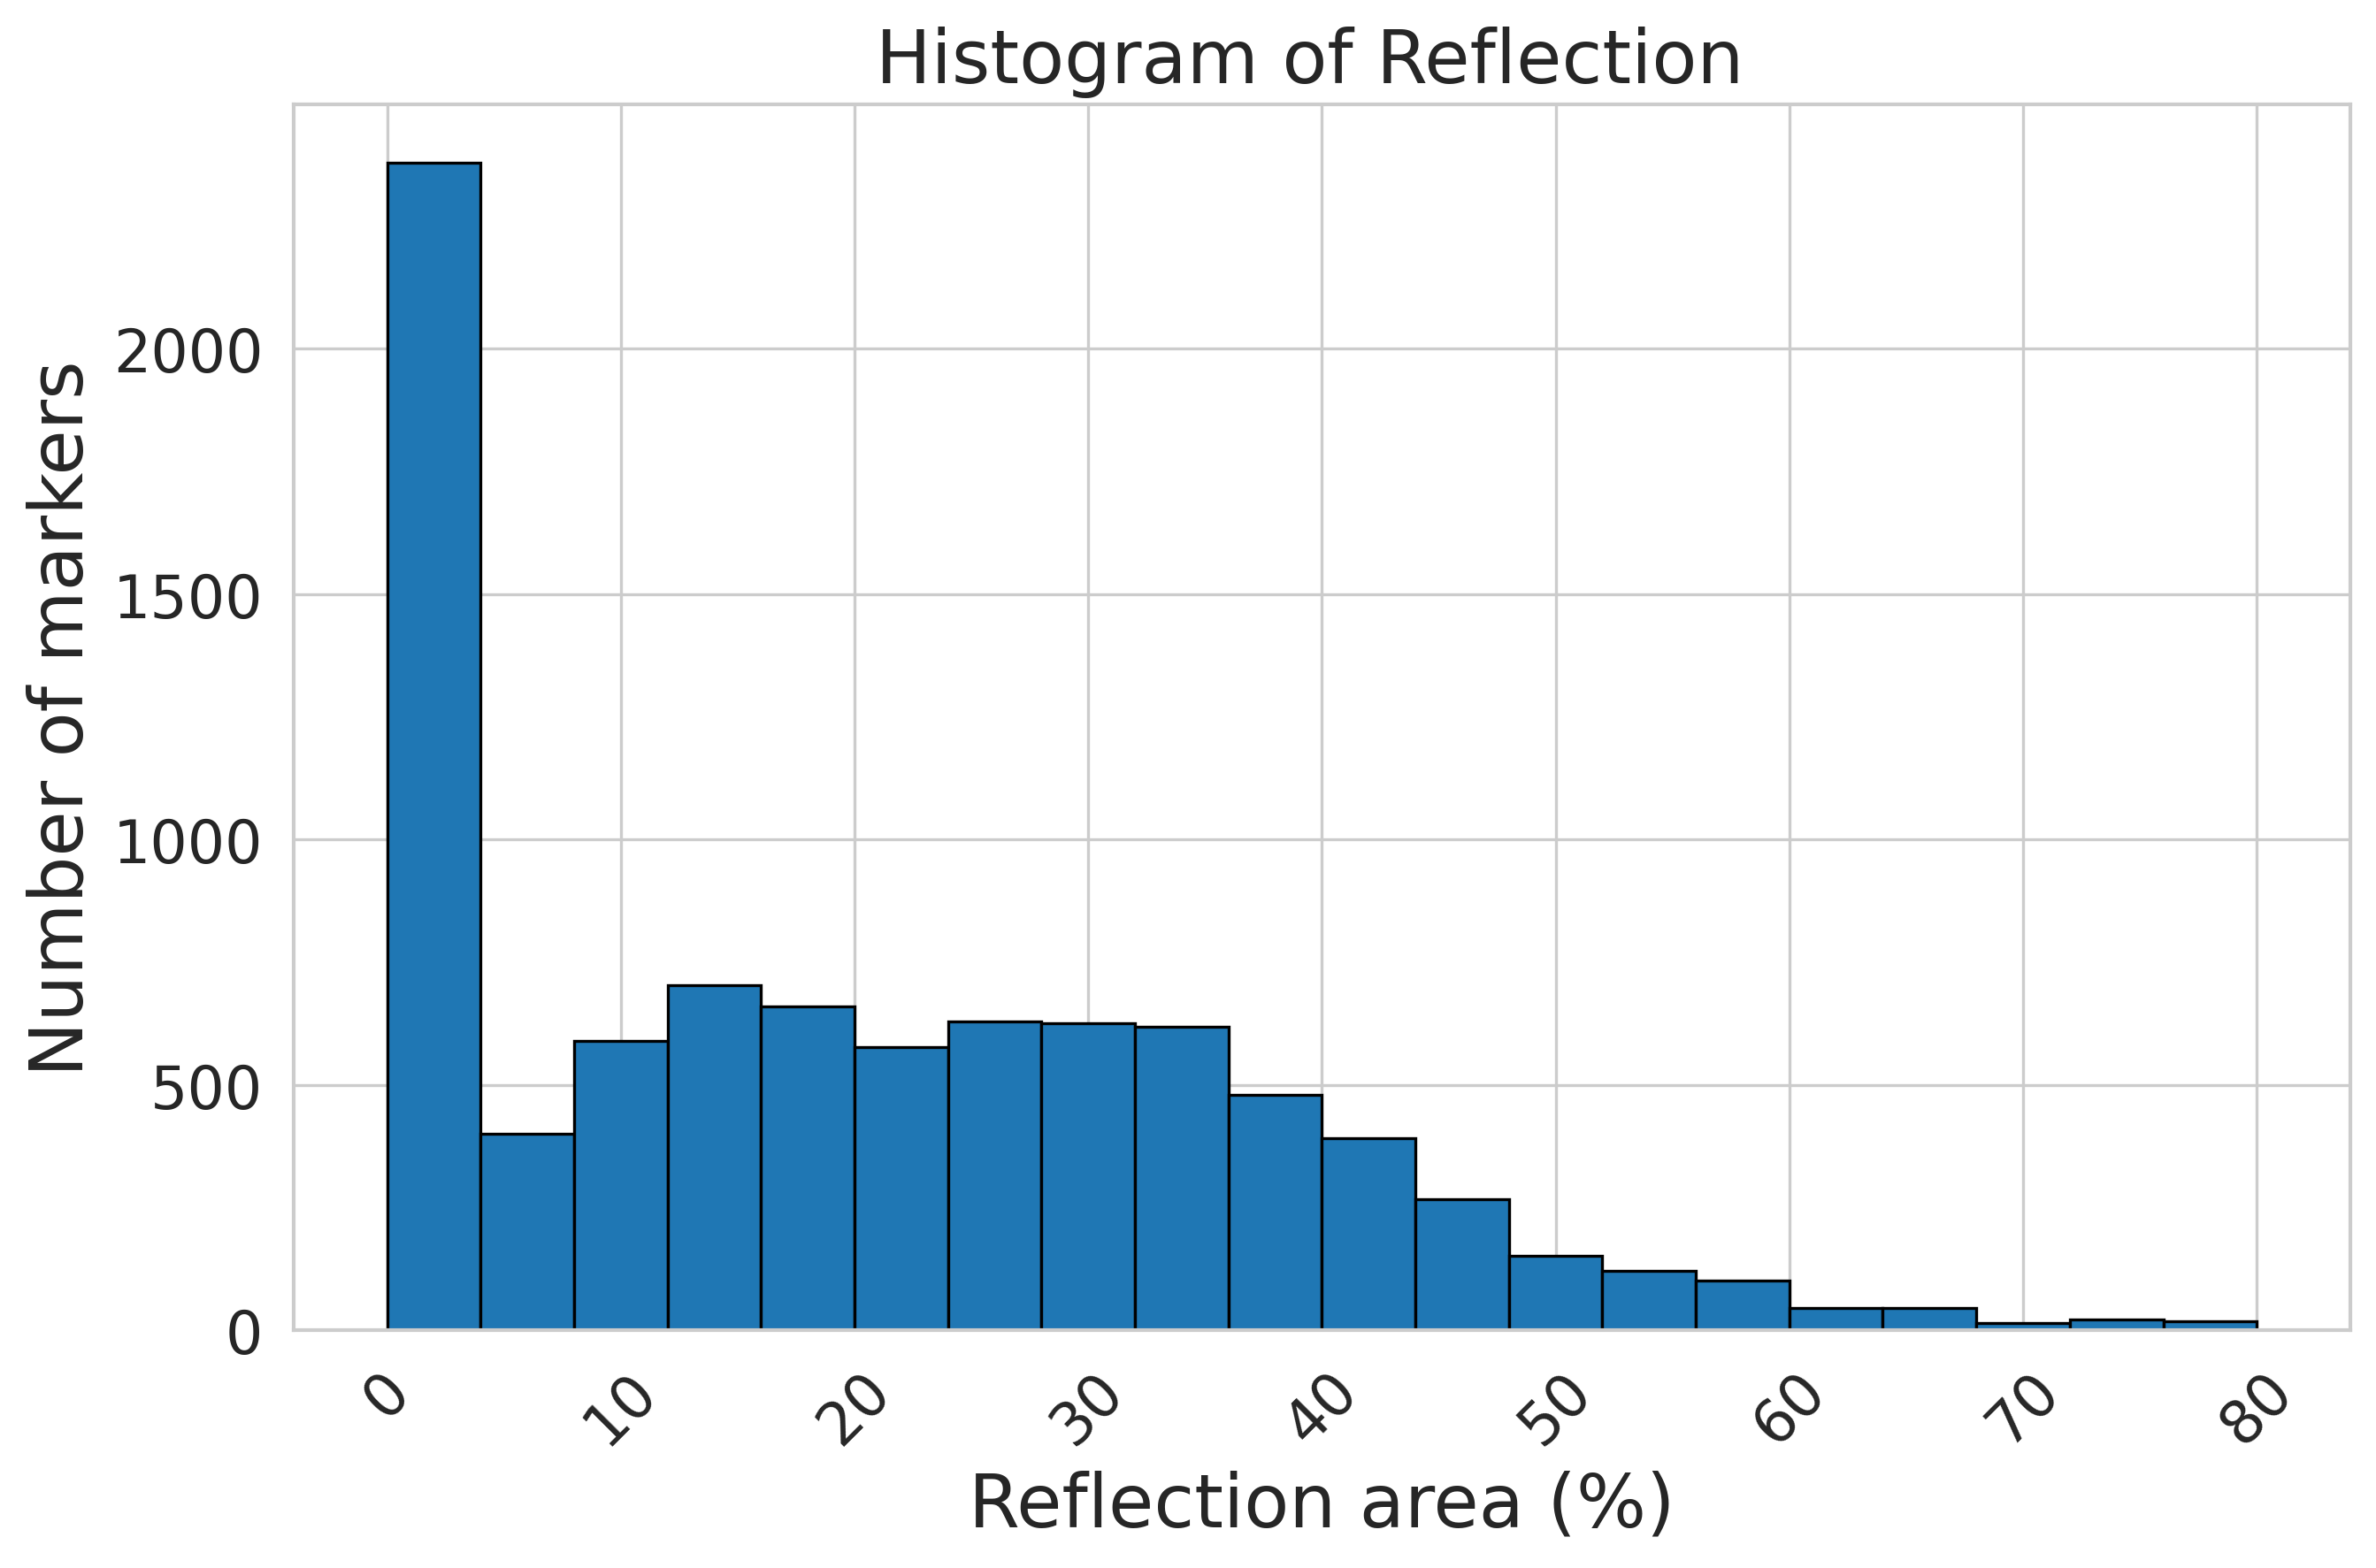

In [9]:
import matplotlib.pyplot as plt

# Filter out zeros from the 'marker_size' column
plt.figure(figsize=(10, 6), dpi=300)  # Higher DPI for better quality
df['reflection'] = pd.to_numeric(df['reflection'], errors='coerce') 
filtered_data = df[df['FP'] == 0]['reflection'].astype(int)

# Create the histogram
plt.hist(filtered_data, bins=20, edgecolor='black')
plt.xlabel('Reflection area (%)', fontsize=20)
plt.ylabel('Number of markers', fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.title('Histogram of Reflection ', fontsize=20)
plt.show()

Apriltag evaluation

In [24]:
import pandas as pd
import csv
import os
import json

def is_bbox_in_bounds(bbox_corners, h, w):
    marker_w = bbox_corners[2][0]-bbox_corners[0][0]
    marker_h = bbox_corners[2][1]-bbox_corners[0][1]
    for x, y in bbox_corners:
        if not (-marker_w/14 <= x <= w+marker_w/14 and -marker_h/14 <= y <= h+marker_h/14):
            return False
    return True  

label_dir   = '../dataset/nested2/labels/test/'
april_path  = '../dataset/nested2/apriltag.csv'
eval_path   = '../dataset/nested2/april_eval_model.csv'

df = pd.read_csv(april_path)

with open(eval_path, 'a', newline='') as eval_file:
	csv_writer = csv.writer(eval_file)
	csv_writer.writerow(['image', 'ID', 'location', 'reflection', 'marker_size', 'size_ratio', 'TP', 'FN'])

	num_match = 0

	for filename in os.listdir(label_dir):
		label_path = label_dir + filename
		im_name = filename.split('.')[0] + '.jpg'
	
		with open(label_path, 'r') as l:
			data = json.load(l)

		true_ids = []
		pred_ids = []
		reflections = []
		locations = ['outer', 'middle', 'inner']
		bboxes = []
		sizes = []
		sizes_ratio = []
		
		for marker in data:
			bbox_ori = marker['bbox_corners']
			image_size = marker['image_size']
			h = image_size[0]
			w = image_size[1]
			im_size = h * w
			if is_bbox_in_bounds(bbox_ori, h, w):
				bbox = [(int(max(0, min(x, w))), int(max(0, min(y, h)))) for x, y in bbox_ori]
				bboxes.append(bbox)
				true_ids.append(marker['tag_id'])
				reflections.append(marker['reflection_area'])
				sizes.append(bbox[2][0]-bbox[0][0])
				w_bbox = bbox[2][0]-bbox[0][0]
				h_bbox = bbox[2][1]-bbox[0][1]
				bbox_size = w_bbox * h_bbox
				sr = bbox_size / im_size
				sizes_ratio.append(sr)
			else:
				del locations[0]

		preds = df[df['image'] == im_name]
		for i in range(len(preds)):
			pred_ids.append(preds.iloc[i][1])

		
		for i in range(len(true_ids)):
			true_id = true_ids[i]
			location = locations[i]
			reflection = reflections[i]
			marker_size = sizes[i]
			size_ratio = sizes_ratio[i]
			TP = 0
			FN = 0
			if true_id in pred_ids:
				TP = 1
			elif true_id not in pred_ids:
				FN = 1
			csv_writer.writerow([im_name, true_id, location, reflection, marker_size, size_ratio, TP, FN])


/tmp/ipykernel_4405/1376142564.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_ids.append(preds.iloc[i][1])


In [68]:
import pandas as pd

csv_path = '../dataset/nested2/detect_eval_model_yolotag.csv'

df = pd.read_csv(csv_path)
dfm = df[df['TP'] == 1]

dfm_outer = dfm[dfm['location'] == 'outer']
dfm_middle = dfm[dfm['location'] == 'middle']
dfm_inner = dfm[dfm['location'] == 'inner']
total = 3000
outer  = len(dfm_outer)  / total
middle = len(dfm_middle) / total
inner  = len(dfm_inner)  / total

unique_image_count = dfm['image'].nunique()
unique_image_count / 3000

print(f'detection rate of multi-scale: {unique_image_count / 3000}')
print(f'detection rate of outer: {outer}')
print(f'detection rate of middle: {middle}')
print(f'detection rate of inner: {inner}')


detection rate of multi-scale: 0.8236666666666667
detection rate of outer: 0.814
detection rate of middle: 0.173
detection rate of inner: 0.004


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

csv_path_april  = '../dataset/nested2/april_eval_model.csv'
csv_path_decode = '../dataset/nested2/decode_eval_model.csv'

dfa = pd.read_csv(csv_path_april)
dfd = pd.read_csv(csv_path_decode)

max_reflection = dfa['reflection'].max()

bins = np.arange(0, max_reflection + 2, 2)
dfa['reflection_bin'] = pd.cut(dfa['reflection'], bins=bins, include_lowest=True, right=False)
agg_dfa = dfa.groupby('reflection_bin').sum().reset_index()
agg_dfa['recall'] = agg_dfa['TP'] / (agg_dfa['TP'] + agg_dfa['FN'])
agg_dfa['recall'].fillna(0, inplace=True)

dfd['reflection_bin'] = pd.cut(dfd['reflection'], bins=bins, include_lowest=True, right=False)
agg_dfd = dfd.groupby('reflection_bin').sum().reset_index()
agg_dfd['recall'] = agg_dfd['TP'] / (agg_dfd['TP'] + agg_dfd['FN'])
agg_dfd['recall'].fillna(0, inplace=True)

# Add values when reflection is 0 for both datasets
dfa_reflection_zero = dfa[dfa['reflection'] == 0]
recall_zero_april = dfa_reflection_zero['TP'].sum() / (dfa_reflection_zero['TP'].sum() + dfa_reflection_zero['FN'].sum())

dfd_reflection_zero = dfd[dfd['reflection'] == 0]
recall_zero_decode = dfd_reflection_zero['TP'].sum() / (dfd_reflection_zero['TP'].sum() + dfd_reflection_zero['FN'].sum())

bin_midpoints = [(interval.left + interval.right) / 2 for interval in agg_dfa['reflection_bin']]

# Add the 0 reflection point to the bin_midpoints and precision/recall
bin_midpoints = [0] + bin_midpoints  # Insert reflection=0
agg_dfa_recall = [recall_zero_april] + list(agg_dfa['recall'])  
agg_dfd_recall = [recall_zero_decode] + list(agg_dfd['recall'])

/tmp/ipykernel_17712/2767053765.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_dfa = dfa.groupby('reflection_bin').sum().reset_index()
/tmp/ipykernel_17712/2767053765.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  agg_dfa['recall'].fillna(0, inplace=True)
/tmp/ipykernel_17712/2767053765.py:20: FutureWarning: The default of

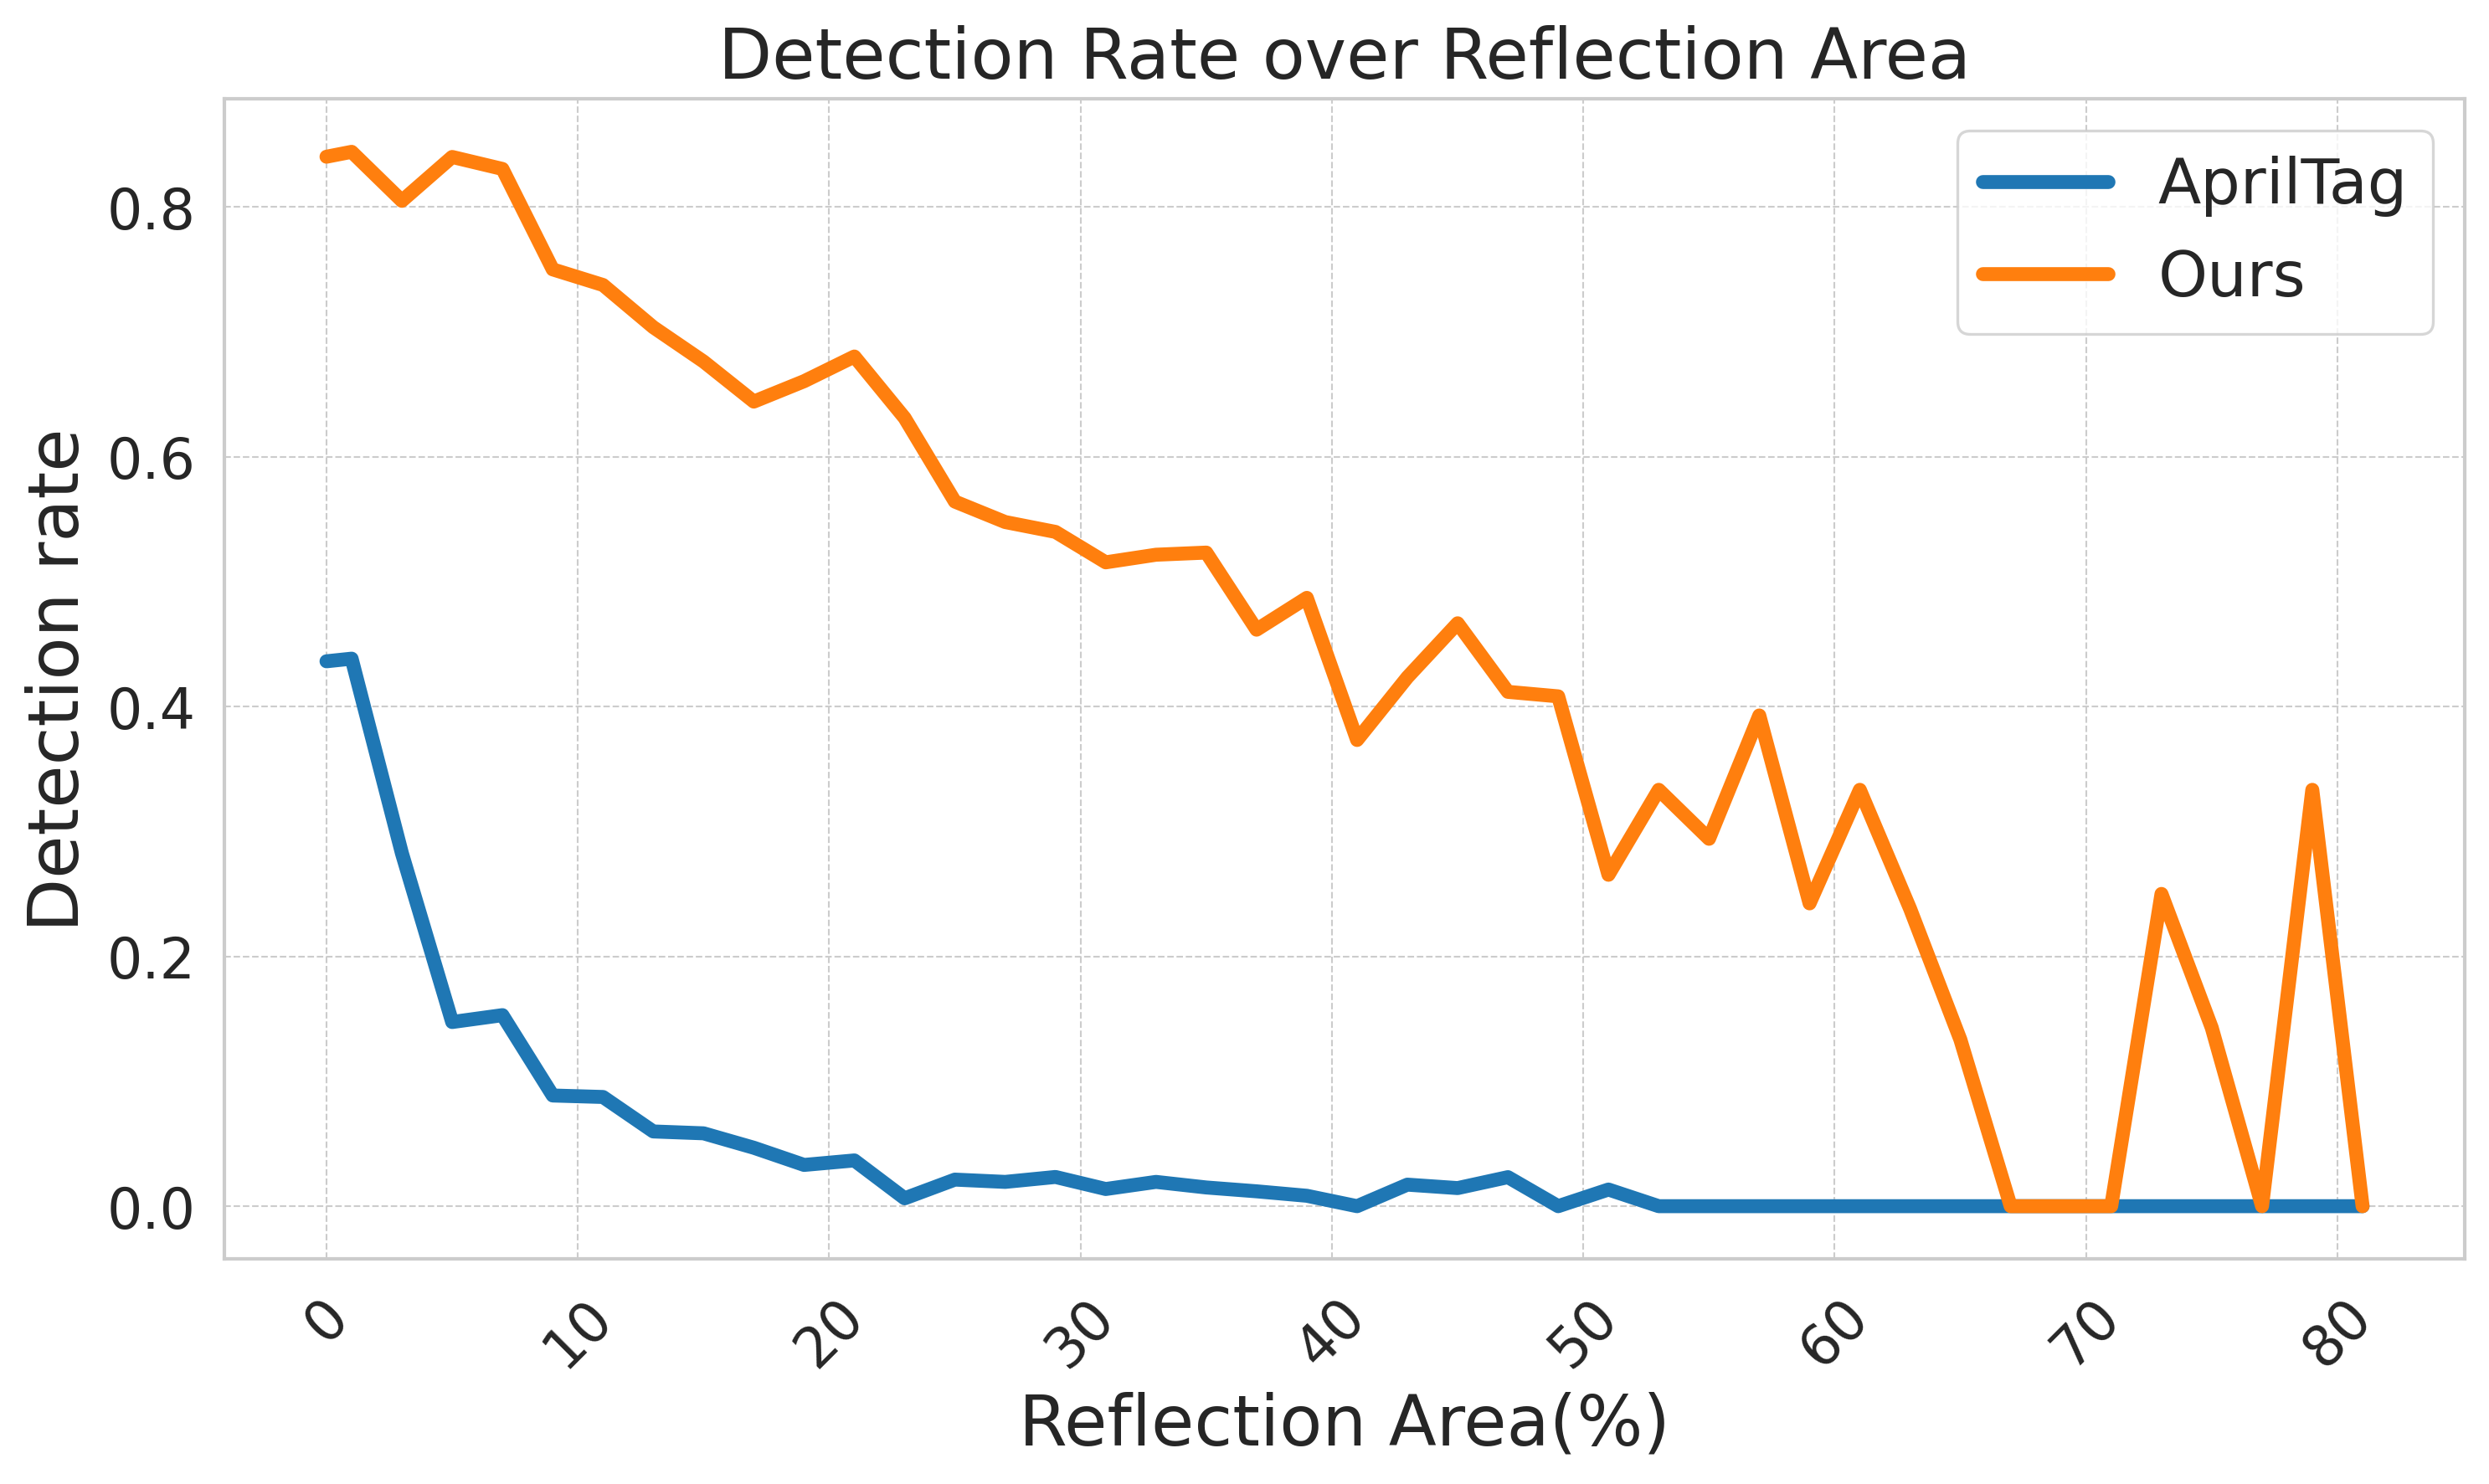

In [42]:
import seaborn as sns

sns.set_context("paper")  # Use "paper" context for smaller-scale plots
sns.set_style("whitegrid")  # Optionally set the style to 'whitegrid'

plt.figure(figsize=(10, 6), dpi=300)  # Higher DPI for better quality

plt.plot(bin_midpoints, agg_dfa_recall, label='AprilTag', linestyle='-', linewidth=4, markersize=8)
plt.plot(bin_midpoints, agg_dfd_recall, label='Ours', linestyle='-', linewidth=4, markersize=8)

# Label the axes with larger font size
plt.xlabel('Reflection Area(%)', fontsize=20)
plt.ylabel('Detection rate', fontsize=20)

# Add a title with a larger font size
plt.title('Detection Rate over Reflection Area', fontsize=20)

# Customize the legend
plt.legend(fontsize=18, frameon=True, bbox_to_anchor=(1, 1))

# Increase the tick size and rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)

# Remove unnecessary grid lines (optional)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot as a high-resolution image if needed for publication
plt.tight_layout()  # This ensures everything fits well into the figure
# Show the plot
plt.show()


In [13]:
import cv2 as cv
im_path = "/home/su/Downloads/extract_contour.jpg"
im_path1 = "/home/su/Downloads/extract_contour1.jpg"
im = cv.imread(im_path)
resized = cv.resize(im, (640, 512), interpolation=cv.INTER_NEAREST)
cv.imwrite(im_path1, resized)


True

Yolotag

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

csv_path_april  = '../dataset/nested2/april_eval_model.csv'
csv_path_yolo  = '../dataset/nested2/detect_eval_model_yolotag.csv'
csv_path_decode = '../dataset/nested2/detect_decode_eval_model.csv'
csv_path_detect = '../dataset/nested2/detect_eval_model_n.csv'

dfy1 = pd.read_csv(csv_path_yolo)
dfd = pd.read_csv(csv_path_decode)
dfa = pd.read_csv(csv_path_april)
dfm = pd.read_csv(csv_path_detect)

dfy = dfy1[dfy1['FP'] == 0]
dfy['reflection'] = pd.to_numeric(dfy['reflection'], errors='coerce')
max_reflection = dfa['reflection'].max()

bins = np.arange(0, max_reflection + 2, 2)
dfa['reflection_bin'] = pd.cut(dfa['reflection'], bins=bins, include_lowest=True, right=False)
agg_dfa = dfa.groupby('reflection_bin').sum().reset_index()
agg_dfa['recall'] = agg_dfa['TP'] / (agg_dfa['TP'] + agg_dfa['FN'])
agg_dfa['recall'].fillna(0, inplace=True)

dfd['reflection_bin'] = pd.cut(dfd['reflection'], bins=bins, include_lowest=True, right=False)
agg_dfd = dfd.groupby('reflection_bin').sum().reset_index()
agg_dfd['recall'] = agg_dfd['TP'] / (agg_dfd['TP'] + agg_dfd['FN'])
agg_dfd['recall'].fillna(0, inplace=True)

dfy['reflection_bin'] = pd.cut(dfy['reflection'], bins=bins, include_lowest=True, right=False)
agg_dfy = dfy.groupby('reflection_bin').sum().reset_index()
agg_dfy['recall'] = agg_dfy['TP'] / (agg_dfy['TP'] + agg_dfy['FN'])
agg_dfy['recall'].fillna(0, inplace=True)

dfm[['reflection', 'TP', 'FP', 'FN']] = dfm[['reflection', 'TP', 'FP', 'FN']].apply(pd.to_numeric, errors='coerce')
dfm['reflection_bin'] = pd.cut(dfm['reflection'], bins=bins, include_lowest=True, right=False)
agg_dfm = dfm.groupby('reflection_bin').sum().reset_index()
agg_dfm['recall'] = agg_dfm['TP'] / (agg_dfm['TP'] + agg_dfm['FN'])
agg_dfm['recall'].fillna(0, inplace=True)


# Add values when reflection is 0 for both datasets
dfa_reflection_zero = dfa[dfa['reflection'] == 0]
recall_zero_april = dfa_reflection_zero['TP'].sum() / (dfa_reflection_zero['TP'].sum() + dfa_reflection_zero['FN'].sum())

dfd_reflection_zero = dfd[dfd['reflection'] == 0]
recall_zero_decode = dfd_reflection_zero['TP'].sum() / (dfd_reflection_zero['TP'].sum() + dfd_reflection_zero['FN'].sum())

dfy_reflection_zero = dfy[dfy['reflection'] == 0]
recall_zero_yolo = dfy_reflection_zero['TP'].sum() / (dfy_reflection_zero['TP'].sum() + dfy_reflection_zero['FN'].sum())

dfm_reflection_zero = dfm[dfm['reflection'] == 0]
recall_zero_detect = dfm_reflection_zero['TP'].sum() / (dfm_reflection_zero['TP'].sum() + dfm_reflection_zero['FN'].sum())

bin_midpoints = [(interval.left + interval.right) / 2 for interval in agg_dfa['reflection_bin']]

# Add the 0 reflection point to the bin_midpoints and precision/recall
bin_midpoints = [0] + bin_midpoints  # Insert reflection=0
agg_dfa_recall = [recall_zero_april] + list(agg_dfa['recall'])  
agg_dfd_recall = [recall_zero_decode] + list(agg_dfd['recall'])
agg_dfy_recall = [recall_zero_yolo] + list(agg_dfy['recall'])
agg_dfm_recall = [recall_zero_detect] + list(agg_dfm['recall'])

/tmp/ipykernel_4405/4099414360.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfy['reflection'] = pd.to_numeric(dfy['reflection'], errors='coerce')
/tmp/ipykernel_4405/4099414360.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_dfa = dfa.groupby('reflection_bin').sum().reset_index()
/tmp/ipykernel_4405/4099414360.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermedia

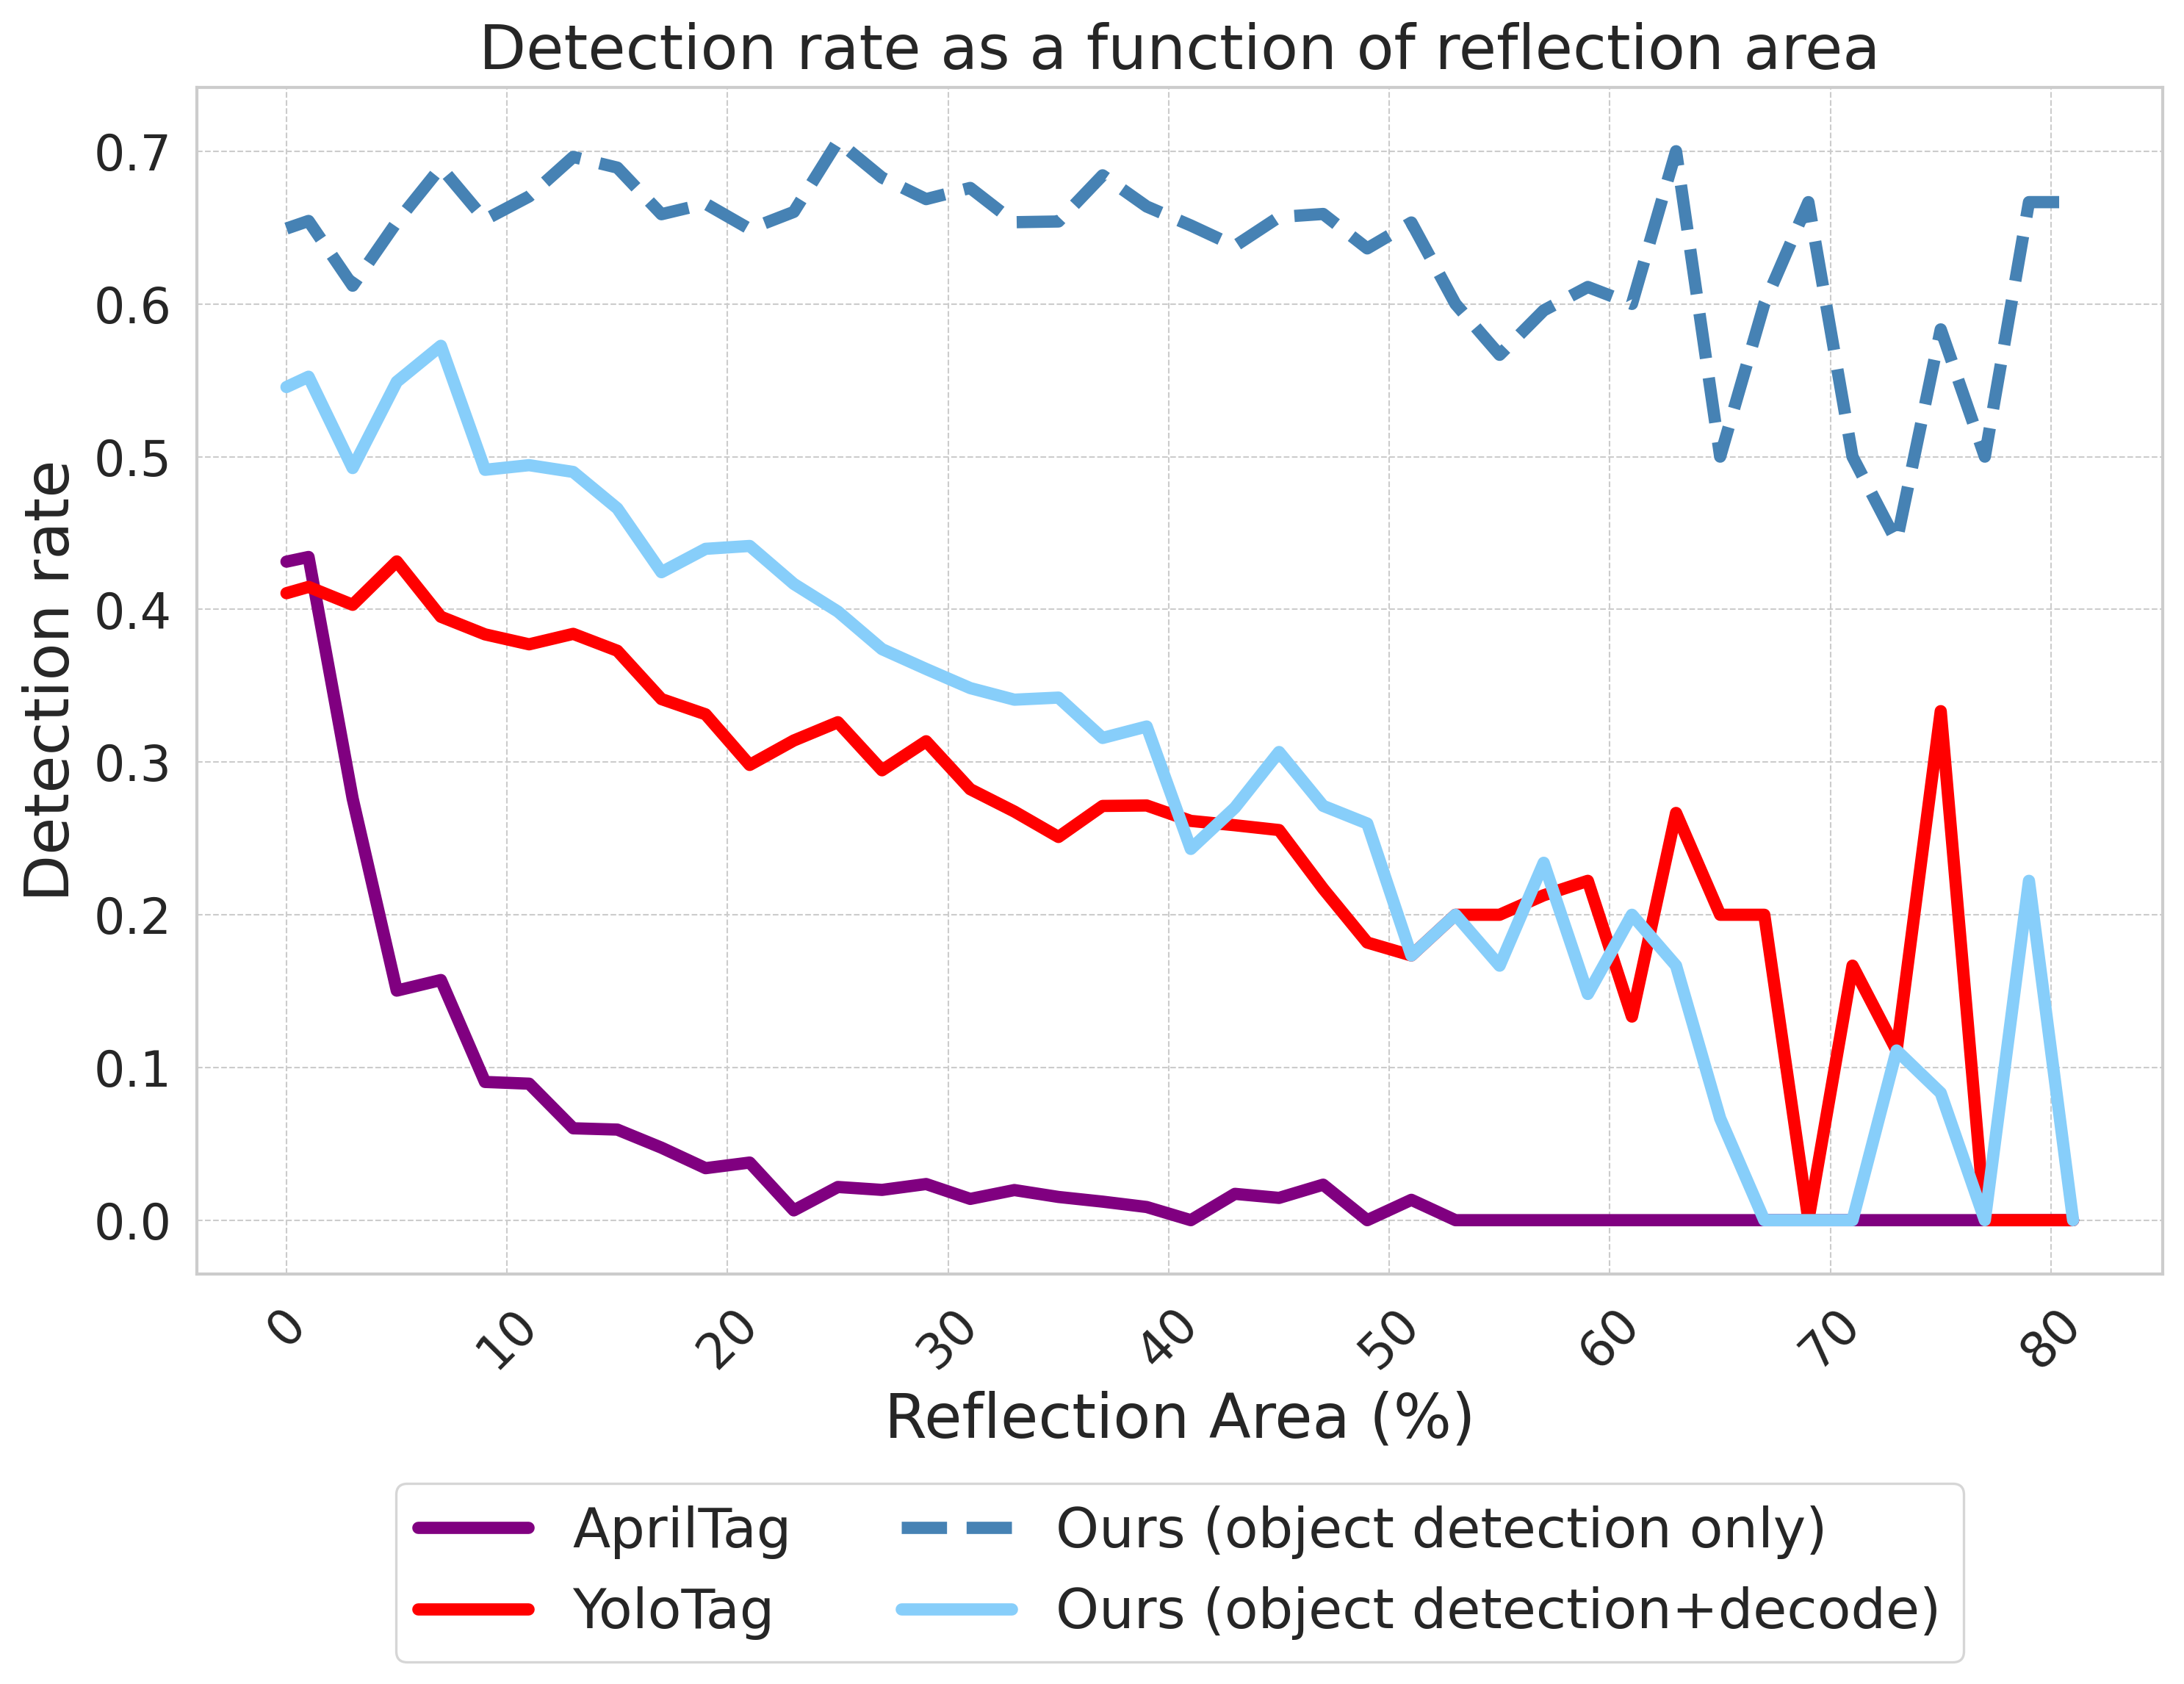

In [115]:
import seaborn as sns

sns.set_context("paper")  # Use "paper" context for smaller-scale plots
sns.set_style("whitegrid")  # Optionally set the style to 'whitegrid'

plt.figure(figsize=(10, 8), dpi=300)  # Higher DPI for better quality

plt.plot(bin_midpoints, agg_dfa_recall, color='purple', label='AprilTag', linestyle='-', linewidth=4, markersize=8)
plt.plot(bin_midpoints, agg_dfy_recall, color='red', label='YoloTag', linestyle='-', linewidth=4, markersize=8)
plt.plot(bin_midpoints, agg_dfm_recall, color='#4682B4', label='Ours (object detection only)', linestyle='--', linewidth=4, markersize=8)
plt.plot(bin_midpoints, agg_dfd_recall, color='#87CEFA', label='Ours (object detection+decode)', linestyle='-', linewidth=4, markersize=8)


plt.xlabel('Reflection Area (%)', fontsize=20)
plt.ylabel('Detection rate', fontsize=20)
plt.title('Detection rate as a function of reflection area', fontsize=20)

# plt.legend(fontsize=18, frameon=True, bbox_to_anchor=(0.6, 0.6))
plt.legend(fontsize=18, frameon=True, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2)

plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)

# Remove unnecessary grid lines (optional)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot as a high-resolution image if needed for publication
plt.tight_layout()  # This ensures everything fits well into the figure
# Show the plot
plt.show()


Marker size comparision

In [93]:
@tf.function(reduce_retracing=True)
def decode_markers(markers):
    return decoder(markers)

start_time = time.time()

csv_path    = '../dataset/nested2/crops/test128.csv'
label_dir   = '../dataset/nested2/labels/test/'
crop_dir    = '../dataset/nested2/crops/test/'
detect_path = '../dataset/nested2/detect_eval_model_n.csv'
eval_path   = '../dataset/nested2/detect_decode_eval_model.csv'

dfd = pd.read_csv(detect_path)
dfd = dfd.loc[dfd['TP'] == 1]
df = pd.read_csv(csv_path)

dfd1 = pd.read_csv(detect_path)
dfd1 = dfd1.loc[dfd1['FN'] == 1]

with open(eval_path, 'a', newline='') as eval_file:
    csv_writer = csv.writer(eval_file)
    csv_writer.writerow(['image', 'location', 'reflection', 'marker_size', 'size_ratio', 'TP', 'FN'])

    num_match = 0

    rot_codes = [cv.ROTATE_90_CLOCKWISE, cv.ROTATE_180, cv.ROTATE_90_COUNTERCLOCKWISE]
    for i in range(dfd.shape[0]):
        id = dfd.iloc[i][1]
        filename = dfd.iloc[i][0] + '_' + id + '.jpg'
        row = df[df['pic'] == filename]

        crop_path = crop_dir + row.iloc[0][0]
        crop = cv.imread(crop_path, cv.IMREAD_GRAYSCALE)

        c1_x = float(row.iloc[0][1])
        c1_y = float(row.iloc[0][2])
        c2_x = float(row.iloc[0][3])
        c2_y = float(row.iloc[0][4])
        c3_x = float(row.iloc[0][5])
        c3_y = float(row.iloc[0][6])
        c4_x = float(row.iloc[0][7])
        c4_y = float(row.iloc[0][8])
        corners = np.array([c1_x, c1_y, c2_x, c2_y, c3_x, c3_y, c4_x, c4_y])
        marker = custom_marker_from_corners(crop, corners, 128)

        orientation = row.iloc[0][10]
        if orientation != 0:
            marker = cv.rotate(marker, rot_codes[orientation - 1])

        markers = [marker]

        decoder_out = np.round(decode_markers(np.array(markers)).numpy())
        id, dist = find_id(decoder_out[0])

        true_id = row.iloc[0][9]
        pred_id = id
        TP = 0
        FN = 0
        if true_id == id:
            TP = 1
            num_match += 1
            print(row.iloc[0][0])
        if true_id != id:
            FN = 1
        reflection = row.iloc[0][11]
        location = dfd.iloc[i][2]
        image_name = dfd.iloc[i][0].split('_')[0]
        marker_size = dfd.iloc[i][4]
        size_ratio = dfd.iloc[i][5]
        csv_writer.writerow([image_name, location, reflection, marker_size, size_ratio, TP, FN])
        
    for i in range(dfd1.shape[0]):
        id = dfd1.iloc[i][1]
        filename = dfd1.iloc[i][0] + '_' + id + '.jpg'
        row = df[df['pic'] == filename]
        TP = 0    
        FN = 1
        reflection = row.iloc[0][11]
        location = dfd1.iloc[i][2]
        image_name = dfd1.iloc[i][0].split('_')[0]
        marker_size = dfd1.iloc[i][4]
        size_ratio = dfd1.iloc[i][5]
        csv_writer.writerow([image_name, location, reflection, marker_size, size_ratio, TP, FN])

/tmp/ipykernel_4405/3310577353.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  id = dfd.iloc[i][1]
/tmp/ipykernel_4405/3310577353.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filename = dfd.iloc[i][0] + '_' + id + '.jpg'
/tmp/ipykernel_4405/3310577353.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  crop_path = crop_dir + row.iloc[0][0]
/tmp/ipykernel_4405/3310577353.py:35: FutureWarning: Series.__getitem__ treating

06349831cbcb8f2c_26.jpg
1ead457c867be1cd_5.jpg
video-4FRnNpmSmwktFJKjg-frame-000746-9CgazXqHXeEATqtKz_27.jpg
video-4FRnNpmSmwktFJKjg-frame-000746-9CgazXqHXeEATqtKz_0.jpg
8af0b106463da353_27.jpg
8af0b106463da353_28.jpg
video-ePoikf5LyTTfqchga-frame-000433-hmHkcDQSQCzqrP8wR_10.jpg
video-ePoikf5LyTTfqchga-frame-000650-Qyt79x8SvYHboeyng_47.jpg
video-ePoikf5LyTTfqchga-frame-000650-Qyt79x8SvYHboeyng_37.jpg
video-4FRnNpmSmwktFJKjg-frame-000860-gSsyewyQdmuhs64dh_48.jpg
video-4FRnNpmSmwktFJKjg-frame-000860-gSsyewyQdmuhs64dh_24.jpg
video-t3f7QC8hZr6zYXpEZ-frame-000180-KCbuiwR8D8fFGLcLJ_44.jpg
video-SCiKdG3MqZfiE292B-frame-007995-atWouMTCk3mtQ8ura_6.jpg
video-SCiKdG3MqZfiE292B-frame-007995-atWouMTCk3mtQ8ura_44.jpg
video-6tLtjdkv5K5BuhB37-frame-000063-rohYmg56KKKu8aTwA_9.jpg
c5517fa7dabdc6a4_4.jpg
c5517fa7dabdc6a4_43.jpg
video-ePoikf5LyTTfqchga-frame-000637-KwCdaZv9oWkoZKjwA_24.jpg
video-ePoikf5LyTTfqchga-frame-000637-KwCdaZv9oWkoZKjwA_31.jpg
video-t3f7QC8hZr6zYXpEZ-frame-000038-nY6GAWq2koFcjLTZf_

/tmp/ipykernel_4405/3310577353.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  id = dfd1.iloc[i][1]
/tmp/ipykernel_4405/3310577353.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filename = dfd1.iloc[i][0] + '_' + id + '.jpg'
/tmp/ipykernel_4405/3310577353.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reflection = row.iloc[0][11]
/tmp/ipykernel_4405/3310577353.py:79: FutureWarning: Series.__getitem__ treating keys a

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


csv_path_model = '../dataset/nested2/detect_eval_model_n.csv'

dfm = pd.read_csv(csv_path_model)

dfm[['marker_size', 'TP', 'FP', 'FN']] = dfm[['marker_size', 'TP', 'FP', 'FN']].apply(pd.to_numeric, errors='coerce')

max_size = dfm['marker_size'].max()

bins = np.arange(0, max_size + 2, 10)
dfm['size_bin'] = pd.cut(dfm['marker_size'], bins=bins, include_lowest=True, right=False)
agg_dfm = dfm.groupby('size_bin').sum().reset_index()
agg_dfm['count'] = agg_dfm['TP'] + agg_dfm['FN']
agg_dfm = agg_dfm.loc[agg_dfm['count'] != 0].reset_index(drop=True)
agg_dfm['TP_frac'] = agg_dfm['TP'] / agg_dfm['count']
agg_dfm['FP_frac'] = agg_dfm['FP'] / agg_dfm['count']
agg_dfm['FN_frac'] = agg_dfm['FN'] / agg_dfm['count']

# bin_midpoints = [(interval.left + interval.right) / 2 for interval in agg_dfm['size_bin']]

agg_dfm_TP = list(agg_dfm['TP_frac'])  
agg_dfm_FP = list(agg_dfm['FP'])
agg_dfm_FN = list(agg_dfm['FN_frac'])  

###################################################################################

csv_path_model = '../dataset/nested2/detect_eval_model_yolotag.csv'

dfy = pd.read_csv(csv_path_model)

dfy[['marker_size', 'TP', 'FP', 'FN']] = dfy[['marker_size', 'TP', 'FP', 'FN']].apply(pd.to_numeric, errors='coerce')

max_size = dfy['marker_size'].max()

dfy['size_bin'] = pd.cut(dfy['marker_size'], bins=bins, include_lowest=True, right=False)
agg_dfy = dfy.groupby('size_bin').sum().reset_index()
agg_dfy['count'] = agg_dfy['TP'] + agg_dfy['FN']
agg_dfy = agg_dfy.loc[agg_dfy['count'] != 0].reset_index(drop=True)
agg_dfy['TP_frac'] = agg_dfy['TP'] / agg_dfy['count']
agg_dfy['FP_frac'] = agg_dfy['FP'] / agg_dfy['count']
agg_dfy['FN_frac'] = agg_dfy['FN'] / agg_dfy['count']

agg_dfy_TP = list(agg_dfy['TP_frac'])  
agg_dfy_FP = list(agg_dfy['FP'])
agg_dfy_FN = list(agg_dfy['FN_frac'])

##################################################################################

csv_path_decode = '../dataset/nested2/detect_decode_eval_model.csv'

dfd = pd.read_csv(csv_path_decode)
dfy[['marker_size', 'TP', 'FN']] = dfy[['marker_size', 'TP', 'FN']].apply(pd.to_numeric, errors='coerce')

dfd['size_bin'] = pd.cut(dfd['marker_size'], bins=bins, include_lowest=True, right=False)
agg_dfd = dfd.groupby('size_bin').sum().reset_index()
agg_dfd['count'] = agg_dfd['TP'] + agg_dfd['FN']
agg_dfd = agg_dfd.loc[agg_dfd['count'] != 0].reset_index(drop=True)
agg_dfd['TP_frac'] = agg_dfd['TP'] / agg_dfd['count']
agg_dfd['FN_frac'] = agg_dfd['FN'] / agg_dfd['count']

bin_midpoints = [(interval.left + interval.right) / 2 for interval in agg_dfd['size_bin']]

agg_dfd_TP = list(agg_dfd['TP_frac'])  
agg_dfd_FN = list(agg_dfd['FN_frac'])  

/tmp/ipykernel_6820/1787682608.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_dfm = dfm.groupby('size_bin').sum().reset_index()
/tmp/ipykernel_6820/1787682608.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_dfy = dfy.groupby('size_bin').sum().reset_index()
/tmp/ipykernel_6820/1787682608.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_dfd = dfd.groupby('size_bin').sum().reset_index()


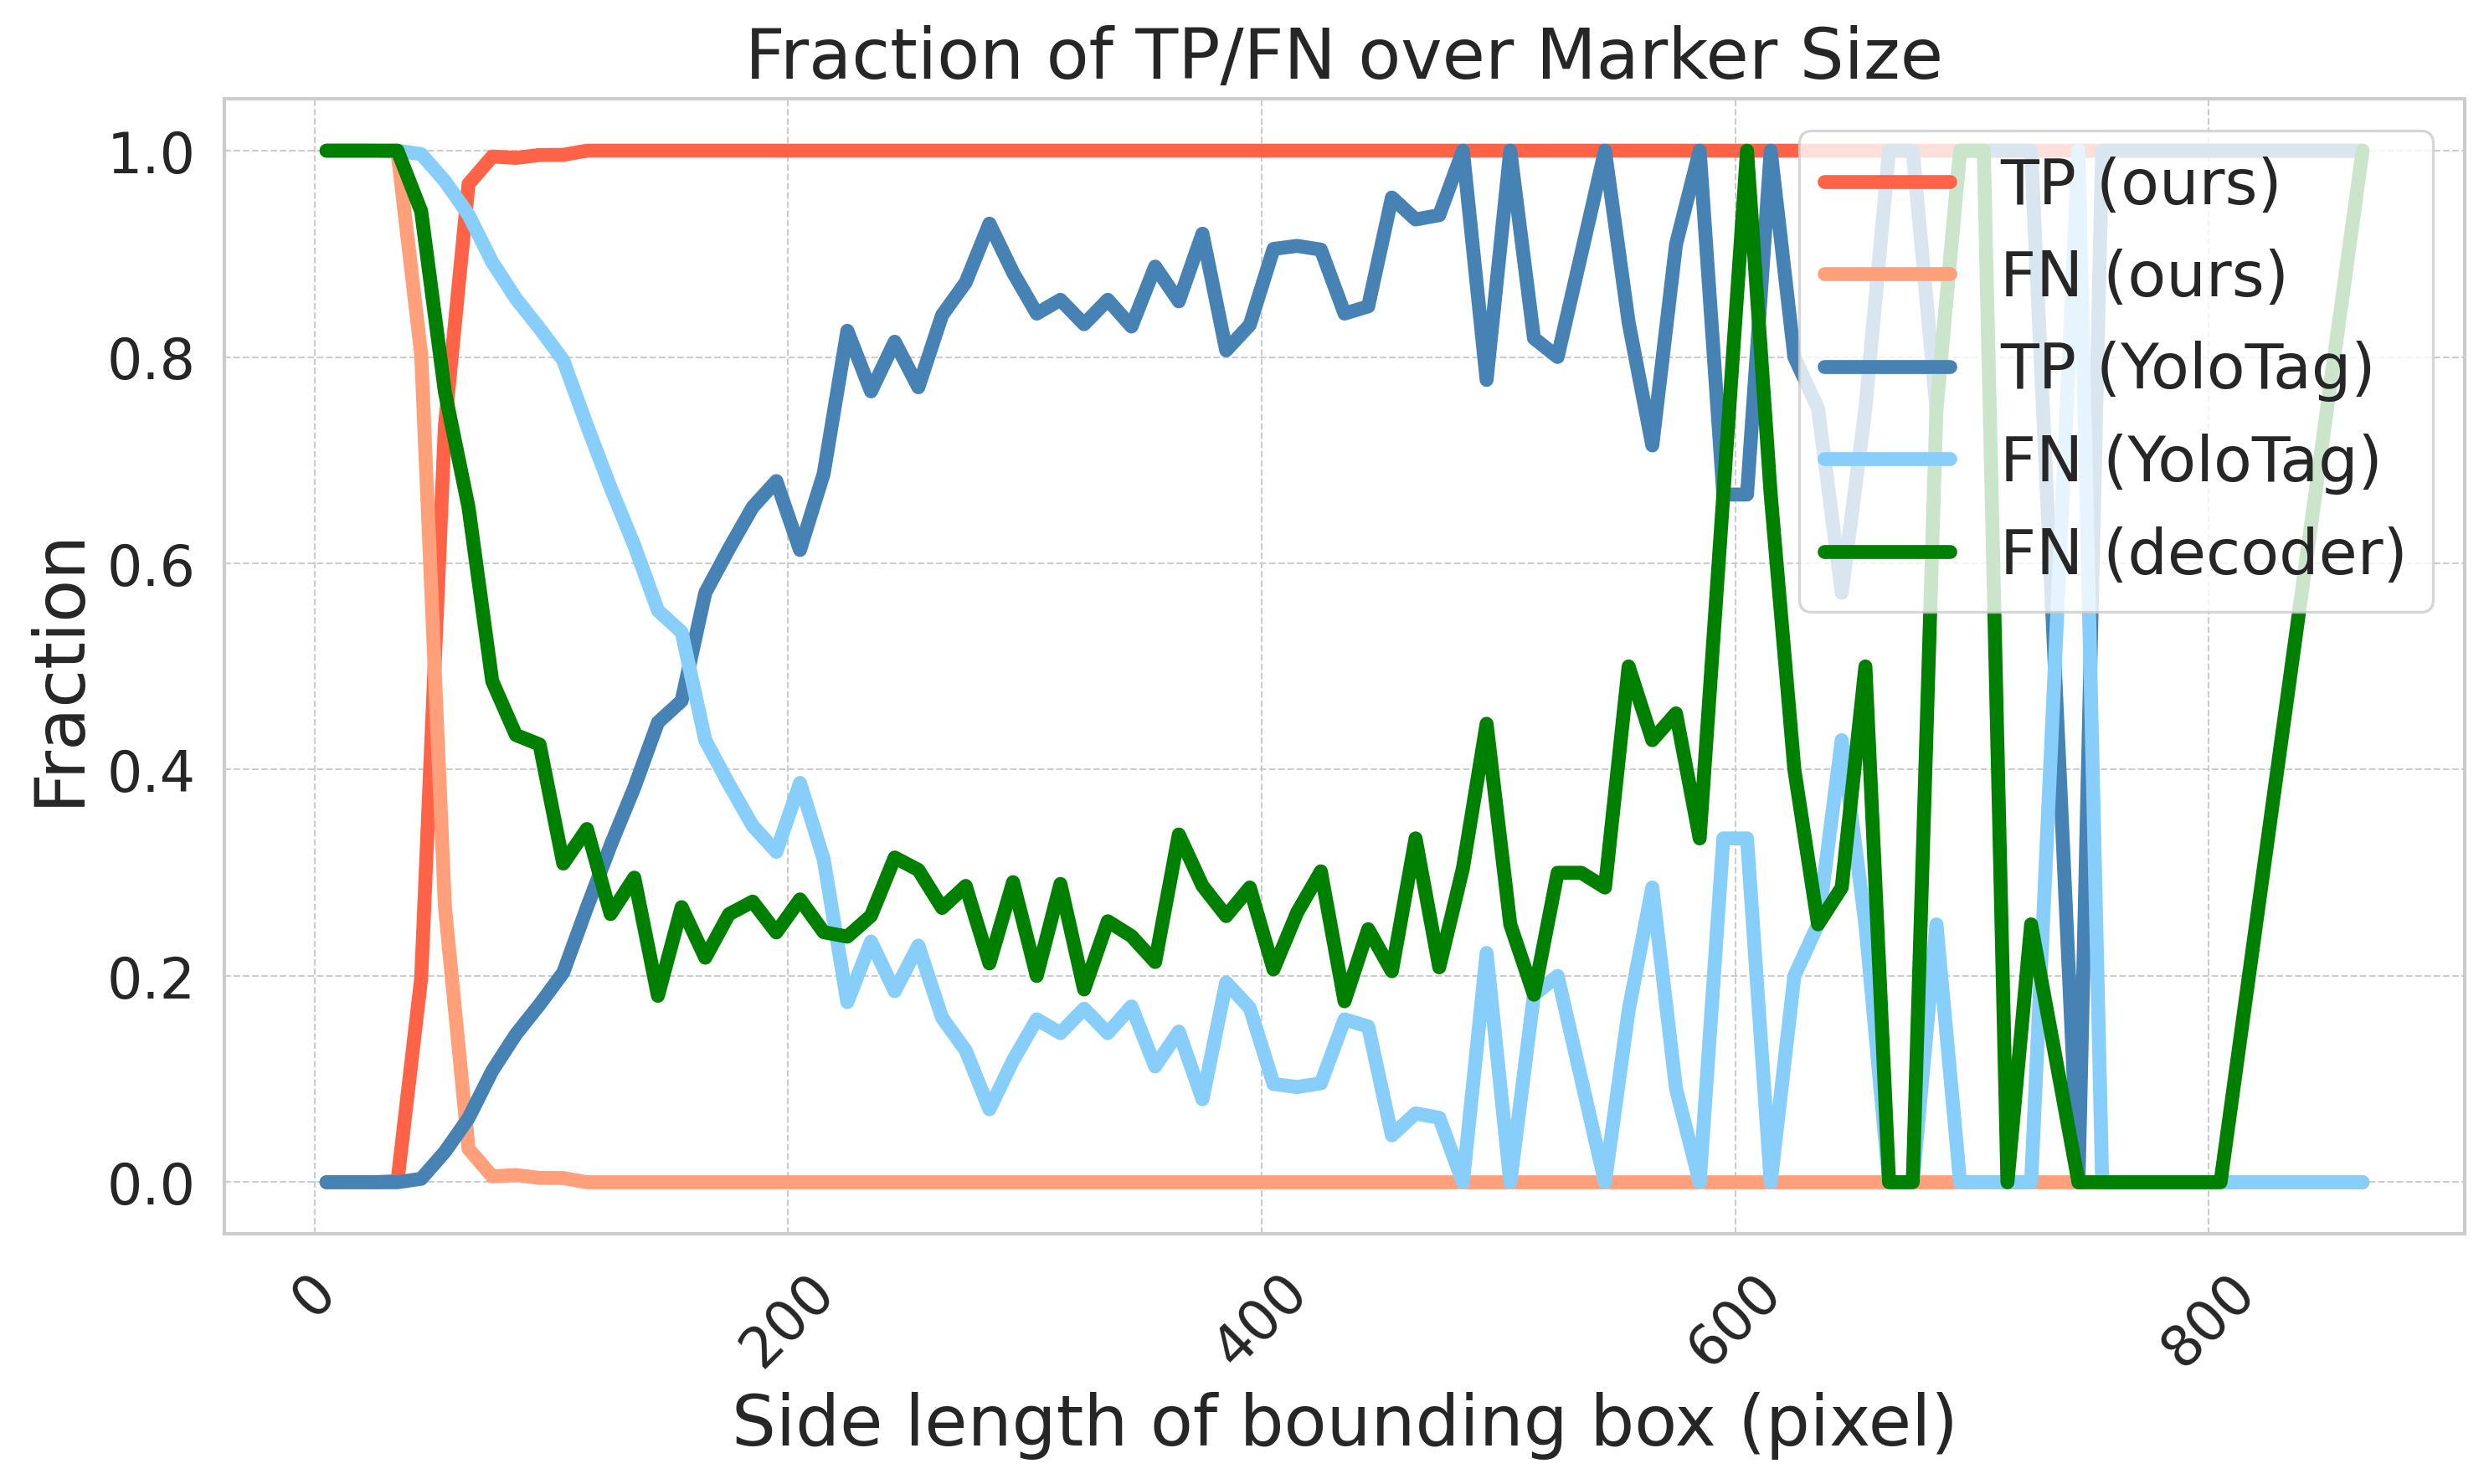

In [101]:
import seaborn as sns

sns.set_context("paper") 
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6), dpi=300)  # Higher DPI for better quality

plt.plot(bin_midpoints, agg_dfm_TP, label='TP (ours)',    color='#FF6347', linestyle='-', linewidth=4, markersize=8)
plt.plot(bin_midpoints, agg_dfm_FN, label='FN (ours)',    color='#FFA07A', linestyle='-', linewidth=4, markersize=8)
plt.plot(bin_midpoints, agg_dfy_TP, label='TP (YoloTag)', color='#4682B4', linestyle='-', linewidth=4, markersize=8)
plt.plot(bin_midpoints, agg_dfy_FN, label='FN (YoloTag)', color='#87CEFA', linestyle='-', linewidth=4, markersize=8)
plt.plot(bin_midpoints, agg_dfd_FN, label='FN (decoder)', color='green', linestyle='-', linewidth=4, markersize=8)

# Label the axes with larger font size
plt.xlabel('Side length of bounding box (pixel)', fontsize=20)
plt.ylabel('Fraction', fontsize=20)

# Add a title with a larger font size
plt.title('Fraction of TP/FN over Marker Size', fontsize=20)

# Customize the legend
plt.legend(fontsize=18, loc='upper right', frameon=True)

# Increase the tick size and rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)

# Remove unnecessary grid lines (optional)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot as a high-resolution image if needed for publication
plt.tight_layout()  # This ensures everything fits well into the figure
# Show the plot
plt.show()


In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

csv_path_april  = '../dataset/nested2/april_eval_model.csv'
csv_path_yolo  = '../dataset/nested2/detect_eval_model_yolotag.csv'
csv_path_decode = '../dataset/nested2/detect_decode_eval_model.csv'
csv_path_detect = '../dataset/nested2/detect_eval_model_n.csv'

dfy1 = pd.read_csv(csv_path_yolo)
dfd = pd.read_csv(csv_path_decode)
dfa = pd.read_csv(csv_path_april)
dfm1 = pd.read_csv(csv_path_detect)

dfy = dfy1[dfy1['FP'] == 0]
dfm = dfm1[dfm1['FP'] == 0]
dfy['size_ratio'] = pd.to_numeric(dfy['size_ratio'], errors='coerce')
dfd['size_ratio'] = pd.to_numeric(dfd['size_ratio'], errors='coerce')
max_size = dfa['size_ratio'].max()


# bins = np.arange(0, max_size + 0.02, 0.02)
bins1 = np.arange(0, 0.5, 0.02)
bins2 = np.arange(0.5, max_size + 0.05, 0.05)
bins = np.unique(np.concatenate((bins1, bins2)))
dfa['marker_size_bin'] = pd.cut(dfa['size_ratio'], bins=bins, include_lowest=True, right=False)
agg_dfa = dfa.groupby('marker_size_bin').sum().reset_index()
agg_dfa['recall'] = agg_dfa['TP'] / (agg_dfa['TP'] + agg_dfa['FN'])
agg_dfa['recall'].fillna(0, inplace=True)

dfd['marker_size_bin'] = pd.cut(dfd['size_ratio'], bins=bins, include_lowest=True, right=False)
agg_dfd = dfd.groupby('marker_size_bin').sum().reset_index()
agg_dfd['recall'] = agg_dfd['TP'] / (agg_dfd['TP'] + agg_dfd['FN'])
agg_dfd['recall'].fillna(0, inplace=True)

dfy['marker_size_bin'] = pd.cut(dfy['size_ratio'], bins=bins, include_lowest=True, right=False)
agg_dfy = dfy.groupby('marker_size_bin').sum().reset_index()
agg_dfy['recall'] = agg_dfy['TP'] / (agg_dfy['TP'] + agg_dfy['FN'])
agg_dfy['recall'].fillna(0, inplace=True)

dfm[['size_ratio', 'TP', 'FP', 'FN']] = dfm[['size_ratio', 'TP', 'FP', 'FN']].apply(pd.to_numeric, errors='coerce')
dfm['marker_size_bin'] = pd.cut(dfm['size_ratio'], bins=bins, include_lowest=True, right=False)
agg_dfm = dfm.groupby('marker_size_bin').sum().reset_index()
agg_dfm['recall'] = agg_dfm['TP'] / (agg_dfm['TP'] + agg_dfm['FN'])
agg_dfm['recall'].fillna(0, inplace=True)


# Add values when size_ratio is 0 for both datasets
dfa_reflection_zero = dfa[dfa['size_ratio'] == 0]
recall_zero_april = dfa_reflection_zero['TP'].sum() / (dfa_reflection_zero['TP'].sum() + dfa_reflection_zero['FN'].sum())

dfd_reflection_zero = dfd[dfd['size_ratio'] == 0]
recall_zero_decode = dfd_reflection_zero['TP'].sum() / (dfd_reflection_zero['TP'].sum() + dfd_reflection_zero['FN'].sum())

dfy_reflection_zero = dfy[dfy['size_ratio'] == 0]
recall_zero_yolo = dfy_reflection_zero['TP'].sum() / (dfy_reflection_zero['TP'].sum() + dfy_reflection_zero['FN'].sum())

dfm_reflection_zero = dfm[dfm['size_ratio'] == 0]
recall_zero_detect = dfm_reflection_zero['TP'].sum() / (dfm_reflection_zero['TP'].sum() + dfm_reflection_zero['FN'].sum())

bin_midpoints = [(interval.left + interval.right) / 2 for interval in agg_dfa['marker_size_bin']]

# Add the 0 size_ratio point to the bin_midpoints and precision/recall
bin_midpoints = [0] + bin_midpoints  
agg_dfa_recall = [recall_zero_april] + list(agg_dfa['recall'])  
agg_dfd_recall = [recall_zero_decode] + list(agg_dfd['recall'])
agg_dfy_recall = [recall_zero_yolo] + list(agg_dfy['recall'])
agg_dfm_recall = [recall_zero_detect] + list(agg_dfm['recall'])

/tmp/ipykernel_4405/1716456864.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfy['size_ratio'] = pd.to_numeric(dfy['size_ratio'], errors='coerce')
/tmp/ipykernel_4405/1716456864.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_dfa = dfa.groupby('marker_size_bin').sum().reset_index()
/tmp/ipykernel_4405/1716456864.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermedi

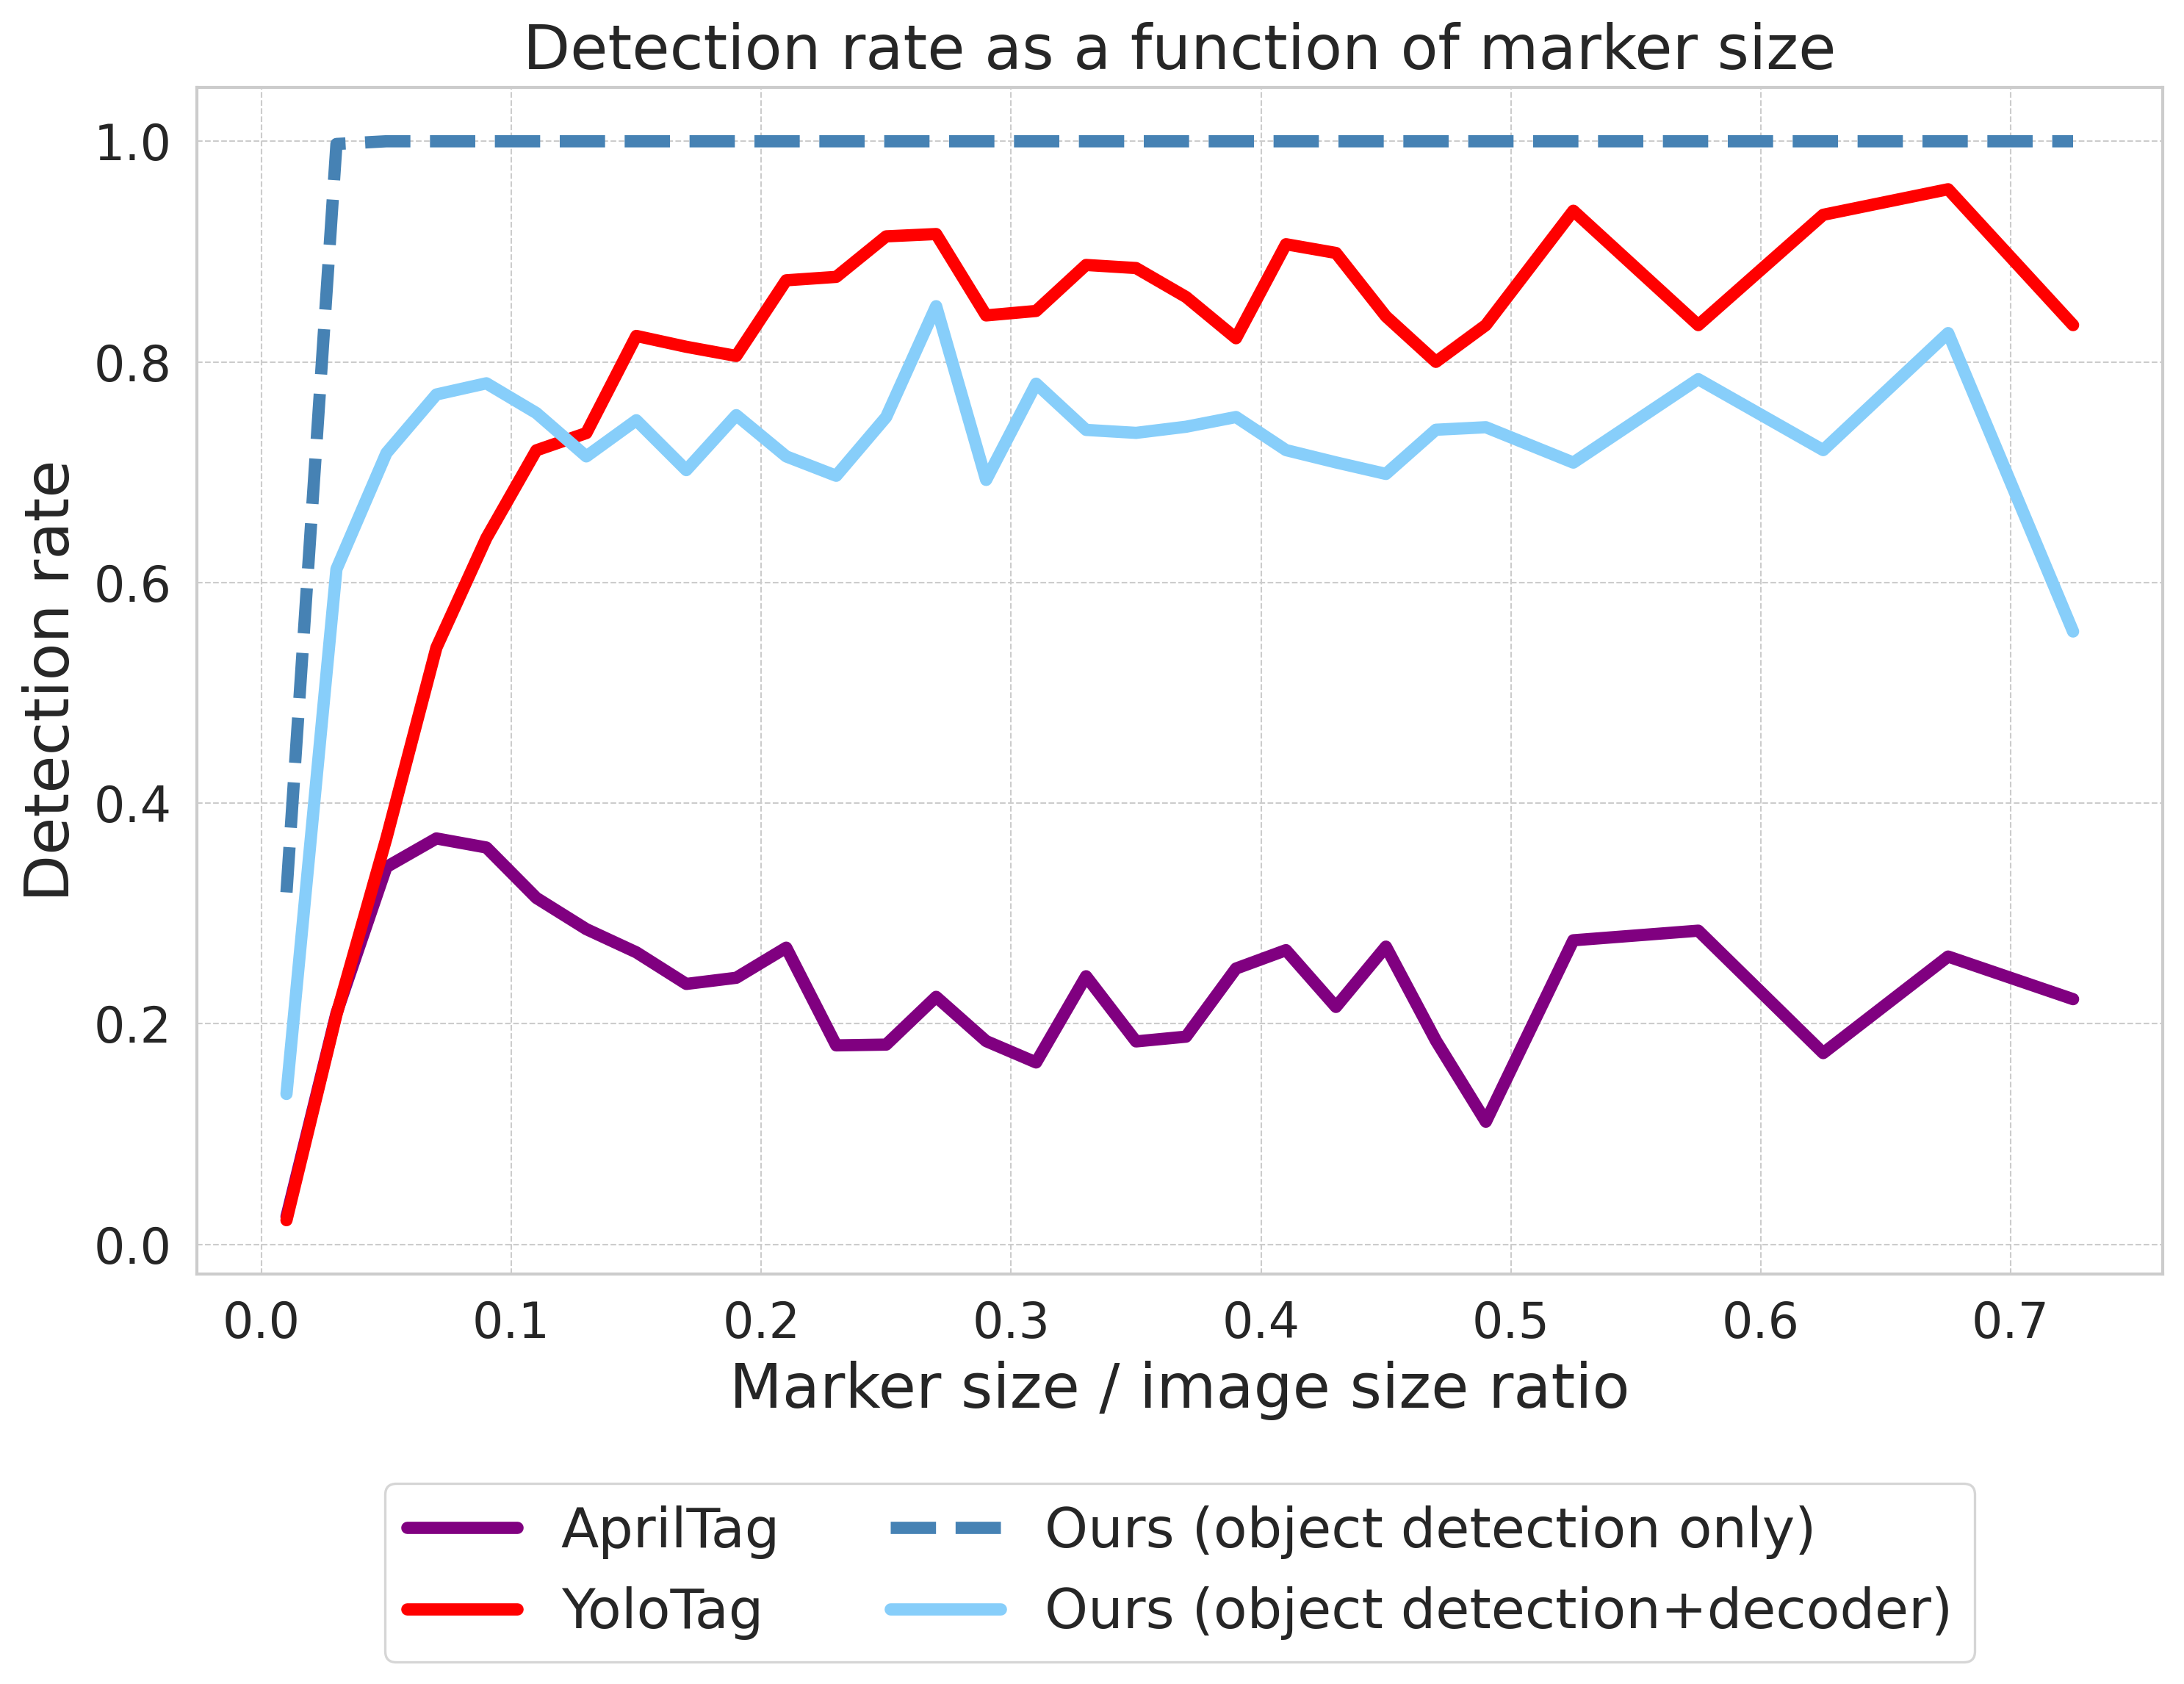

In [113]:
import seaborn as sns

sns.set_context("paper")  # Use "paper" context for smaller-scale plots
sns.set_style("whitegrid")  # Optionally set the style to 'whitegrid'

plt.figure(figsize=(10, 8), dpi=300)  # Higher DPI for better quality

plt.plot(bin_midpoints, agg_dfa_recall, color='purple', label='AprilTag', linestyle='-', linewidth=4, markersize=8)
plt.plot(bin_midpoints, agg_dfy_recall, color='red', label='YoloTag', linestyle='-', linewidth=4, markersize=8)
plt.plot(bin_midpoints, agg_dfm_recall, color='#4682B4', label='Ours (object detection only)', linestyle='--', linewidth=4, markersize=8)
plt.plot(bin_midpoints, agg_dfd_recall, color='#87CEFA', label='Ours (object detection+decoder)', linestyle='-', linewidth=4, markersize=8)

plt.xlabel('Marker size / image size ratio', fontsize=20)
plt.ylabel('Detection rate', fontsize=20)

plt.title('Detection rate as a function of marker size', fontsize=20)
plt.legend(fontsize=18, frameon=True, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout() 
plt.show()

